## Project 1: Flight Price Prediction (Regression)


In [476]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import mlflow
import mlflow.sklearn
import warnings
import pickle
warnings.filterwarnings('ignore')

### Data Preprocessing

In [478]:
# Load the dataset

df = pd.read_csv('Flight_Price.csv')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [201]:
df.shape

(10683, 11)

In [480]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [482]:
#finding the null values
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [484]:
#Drop missing or nullvalues entries
df.dropna(inplace=True)

In [486]:
df.dtypes # datatypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [488]:
# Convert date and time columns
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
df['Journey_Month'] = df['Date_of_Journey'].dt.month
df['Journey_Day'] = df['Date_of_Journey'].dt.day

In [490]:
# dropping unwanted columns
df.drop('Date_of_Journey', axis=1, inplace=True)

In [492]:
# Convert departure and arrival times
df['Dep_Time'] = pd.to_datetime(df['Dep_Time']).dt.strftime('%H:%M')
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time']).dt.strftime('%H:%M')
df['Dep_Hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
df['Dep_Minute'] = pd.to_datetime(df['Dep_Time']).dt.minute
df['Arrival_Hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['Arrival_Minute'] = pd.to_datetime(df['Arrival_Time']).dt.minute

In [494]:
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,IndiGo,Banglore,New Delhi,BLR ? DEL,22:20,01:10,2h 50m,non-stop,No info,3897,3,24,22,20,1,10
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25,19h,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302,3,1,16,50,21,35


In [496]:
# dropping unwanted columns
df.drop('Dep_Time', axis=1, inplace=True)
df.drop('Arrival_Time', axis=1, inplace=True)

In [498]:
# Convert duration to minutes
def convert_to_minutes(duration):
    hours = 0
    minutes = 0

    if 'h' in duration:
        hours = int(duration.split('h')[0])
        duration = duration.split('h')[1]  # Get remaining part after 'h'

    if 'm' in duration:
        minutes = int(duration.replace('m', ''))

    return hours * 60 + minutes

In [500]:
# Process duration
df['Duration_mins'] = df['Duration'].apply(convert_to_minutes)

In [502]:
df.dtypes

Airline            object
Source             object
Destination        object
Route              object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
Journey_Month       int32
Journey_Day         int32
Dep_Hour            int32
Dep_Minute          int32
Arrival_Hour        int32
Arrival_Minute      int32
Duration_mins       int64
dtype: object

### Feature engineering

In [504]:
df['Price_per_minute'] = df['Price'] / df['Duration_mins']

In [506]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_mins,Price_per_minute
0,IndiGo,Banglore,New Delhi,BLR ? DEL,2h 50m,non-stop,No info,3897,3,24,22,20,1,10,170,22.923529
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15,445,17.217978
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,19h,2 stops,No info,13882,6,9,9,25,4,25,1140,12.177193
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30,325,19.132308
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35,285,46.673684


In [508]:
# dropping unwanted columns

df.drop('Duration', axis=1, inplace=True)

### Handling categorical data

In [510]:
# Split Route into multiple columns

df['Route'] = df['Route'].astype(str)

In [512]:
# Split Route into multiple columns
df[["Route_1", "Route_2", "Route_3", "Route_4", "Route_5", "Route_6"]] = df['Route'].str.split(r'\s?\?\s?', expand=True, n=5)

In [514]:
df.fillna("None", inplace=True)

In [516]:
df.drop(columns=['Route'], inplace=True)

In [518]:
df.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_mins,Price_per_minute,Route_1,Route_2,Route_3,Route_4,Route_5,Route_6
0,IndiGo,Banglore,New Delhi,non-stop,No info,3897,3,24,22,20,1,10,170,22.923529,BLR,DEL,None,None,None,None
1,Air India,Kolkata,Banglore,2 stops,No info,7662,5,1,5,50,13,15,445,17.217978,CCU,IXR,BBI,BLR,None,None
2,Jet Airways,Delhi,Cochin,2 stops,No info,13882,6,9,9,25,4,25,1140,12.177193,DEL,LKO,BOM,COK,None,None
3,IndiGo,Kolkata,Banglore,1 stop,No info,6218,5,12,18,5,23,30,325,19.132308,CCU,NAG,BLR,None,None,None
4,IndiGo,Banglore,New Delhi,1 stop,No info,13302,3,1,16,50,21,35,285,46.673684,BLR,NAG,DEL,None,None,None


In [520]:
df.dtypes

Airline              object
Source               object
Destination          object
Total_Stops          object
Additional_Info      object
Price                 int64
Journey_Month         int32
Journey_Day           int32
Dep_Hour              int32
Dep_Minute            int32
Arrival_Hour          int32
Arrival_Minute        int32
Duration_mins         int64
Price_per_minute    float64
Route_1              object
Route_2              object
Route_3              object
Route_4              object
Route_5              object
Route_6              object
dtype: object

In [522]:
# Identify categorical and numerical columns
categorical_cols_label = ['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info', "Route_1", "Route_2", "Route_3", "Route_4", "Route_5", "Route_6"]
numerical_cols = ['Journey_Day', 'Journey_Month', 'Dep_Hour', 'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute', 'Price_per_minute', 'Duration_mins']

In [524]:
# Initialize dictionary to store label encoders
encoders = {}
# Encode each categorical column
for col in categorical_cols_label:
    encoders[col] = LabelEncoder()
    df[f'{col}_Encoded'] = encoders[col].fit_transform(df[col])
        
    # Print mapping for reference
    mapping = dict(zip(encoders[col].classes_, encoders[col].transform(encoders[col].classes_)))
    print(f"\nEncoding mapping for {col}:")
    print(mapping)


Encoding mapping for Airline:
{'Air Asia': 0, 'Air India': 1, 'GoAir': 2, 'IndiGo': 3, 'Jet Airways': 4, 'Jet Airways Business': 5, 'Multiple carriers': 6, 'Multiple carriers Premium economy': 7, 'SpiceJet': 8, 'Trujet': 9, 'Vistara': 10, 'Vistara Premium economy': 11}

Encoding mapping for Source:
{'Banglore': 0, 'Chennai': 1, 'Delhi': 2, 'Kolkata': 3, 'Mumbai': 4}

Encoding mapping for Destination:
{'Banglore': 0, 'Cochin': 1, 'Delhi': 2, 'Hyderabad': 3, 'Kolkata': 4, 'New Delhi': 5}

Encoding mapping for Total_Stops:
{'1 stop': 0, '2 stops': 1, '3 stops': 2, '4 stops': 3, 'non-stop': 4}

Encoding mapping for Additional_Info:
{'1 Long layover': 0, '1 Short layover': 1, '2 Long layover': 2, 'Business class': 3, 'Change airports': 4, 'In-flight meal not included': 5, 'No Info': 6, 'No check-in baggage included': 7, 'No info': 8, 'Red-eye flight': 9}

Encoding mapping for Route_1:
{'BLR': 0, 'BOM': 1, 'CCU': 2, 'DEL': 3, 'MAA': 4}

Encoding mapping for Route_2:
{'AMD': 0, 'ATQ': 1, 'BB

In [404]:
# Apply Label Encoding to all categorical columns
df_encoded = df.copy()
label_encoder = LabelEncoder()
for col in categorical_cols_label:
    df_encoded[col + '_encoded'] = label_encoder.fit_transform(df_encoded[col].astype(str))

In [406]:
df_encoded.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,...,Source_encoded,Destination_encoded,Total_Stops_encoded,Additional_Info_encoded,Route_1_encoded,Route_2_encoded,Route_3_encoded,Route_4_encoded,Route_5_encoded,Route_6_encoded
0,IndiGo,Banglore,New Delhi,non-stop,No info,3897,3,24,22,20,...,0,5,4,8,0,10,21,10,4,1
1,Air India,Kolkata,Banglore,2 stops,No info,7662,5,1,5,50,...,3,0,1,8,2,20,1,3,4,1
2,Jet Airways,Delhi,Cochin,2 stops,No info,13882,6,9,9,25,...,2,1,1,8,3,27,4,5,4,1
3,IndiGo,Kolkata,Banglore,1 stop,No info,6218,5,12,18,5,...,3,0,0,8,2,29,3,10,4,1
4,IndiGo,Banglore,New Delhi,1 stop,No info,13302,3,1,16,50,...,0,5,0,8,0,29,7,10,4,1


In [408]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Airline                  10682 non-null  object 
 1   Source                   10682 non-null  object 
 2   Destination              10682 non-null  object 
 3   Total_Stops              10682 non-null  object 
 4   Additional_Info          10682 non-null  object 
 5   Price                    10682 non-null  int64  
 6   Journey_Month            10682 non-null  int32  
 7   Journey_Day              10682 non-null  int32  
 8   Dep_Hour                 10682 non-null  int32  
 9   Dep_Minute               10682 non-null  int32  
 10  Arrival_Hour             10682 non-null  int32  
 11  Arrival_Minute           10682 non-null  int32  
 12  Duration_mins            10682 non-null  int64  
 13  Price_per_minute         10682 non-null  float64
 14  Route_1                  10

### EDA

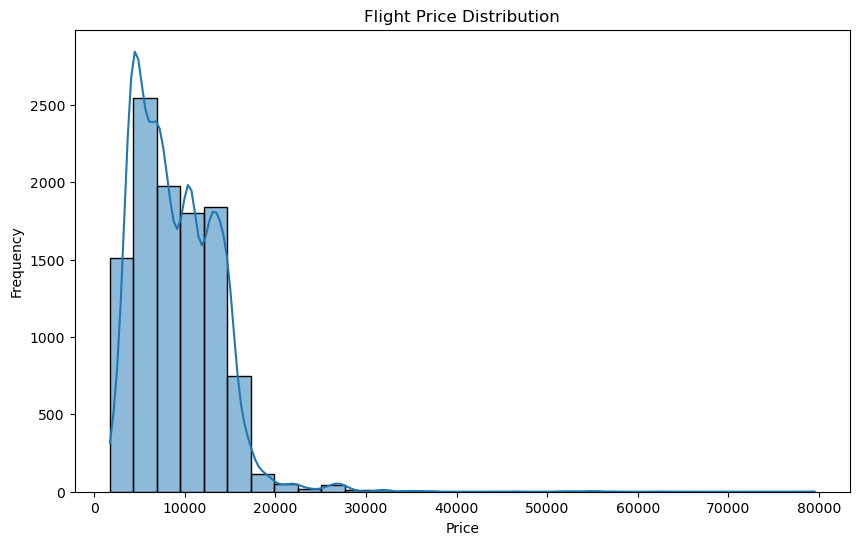

In [410]:
# Plot flight price distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Flight Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

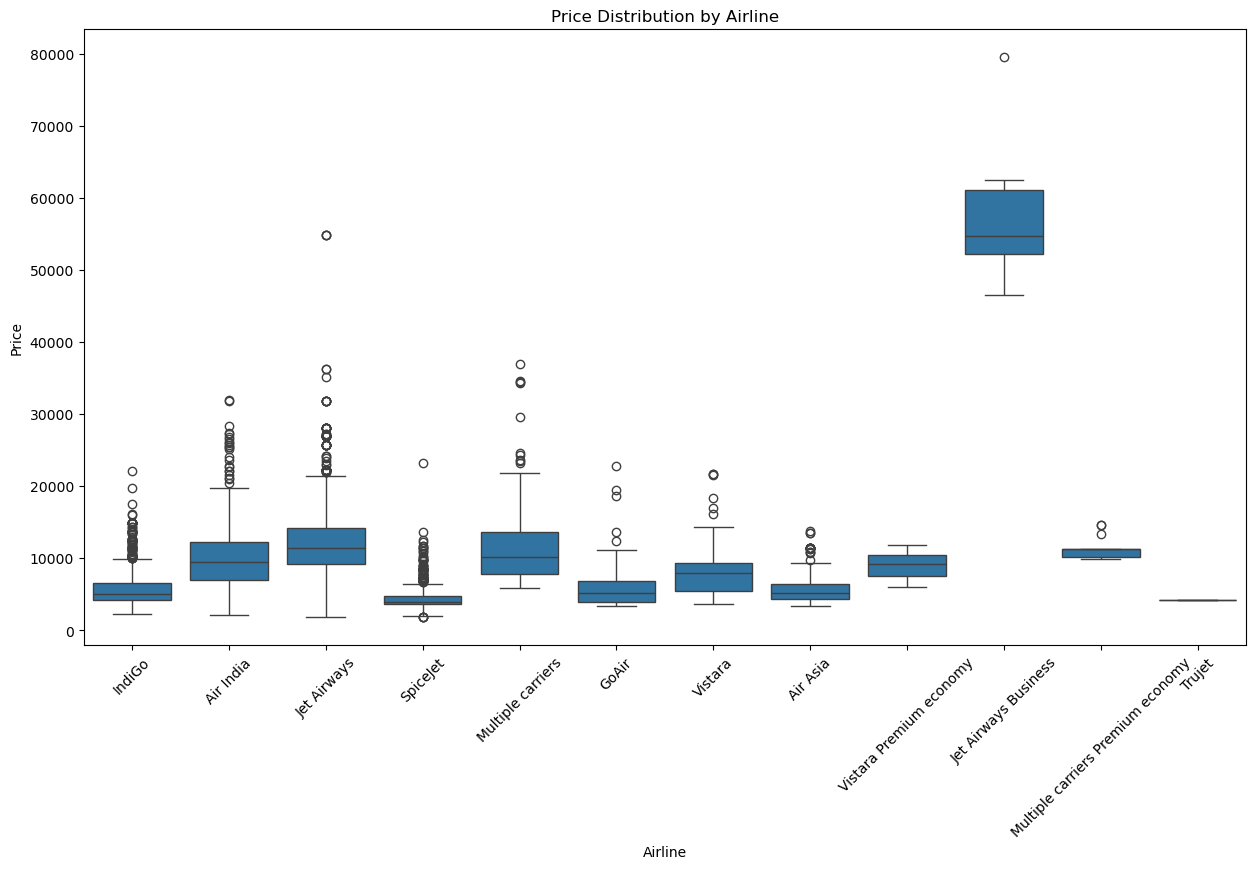

In [412]:
# Price Distribution by Airline
plt.figure(figsize=(15, 8))
sns.boxplot(x='Airline', y='Price', data=df)
plt.xticks(rotation=45)
plt.title('Price Distribution by Airline')
plt.show()

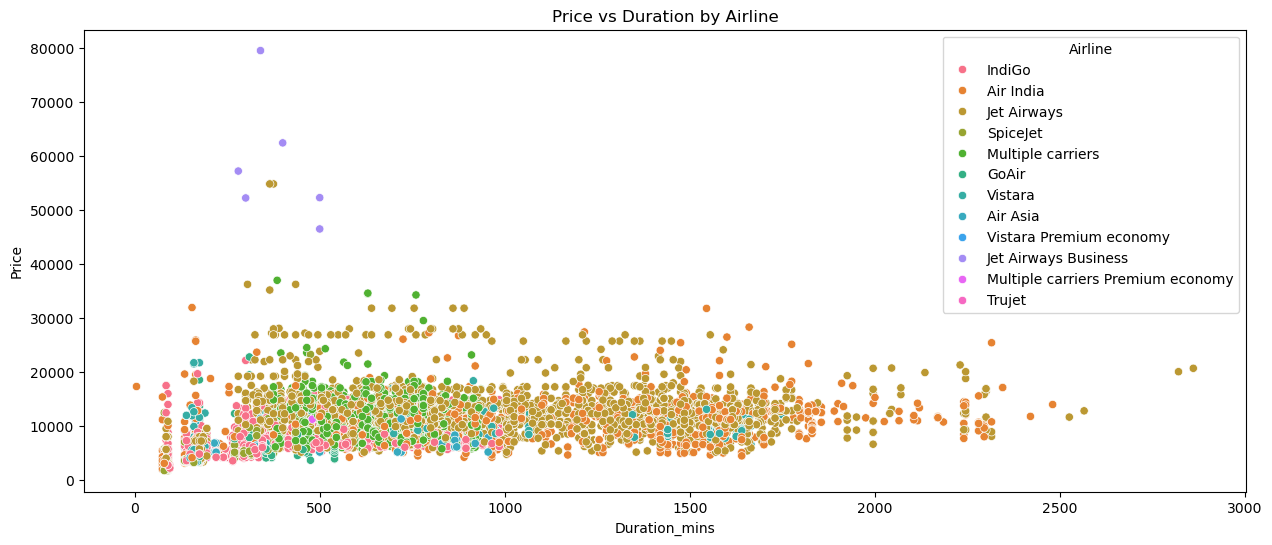

In [414]:
# Price vs Duration by Airline
plt.figure(figsize=(15, 6))
sns.scatterplot(data=df, x='Duration_mins', y='Price', hue='Airline')
plt.title('Price vs Duration by Airline')
plt.show()

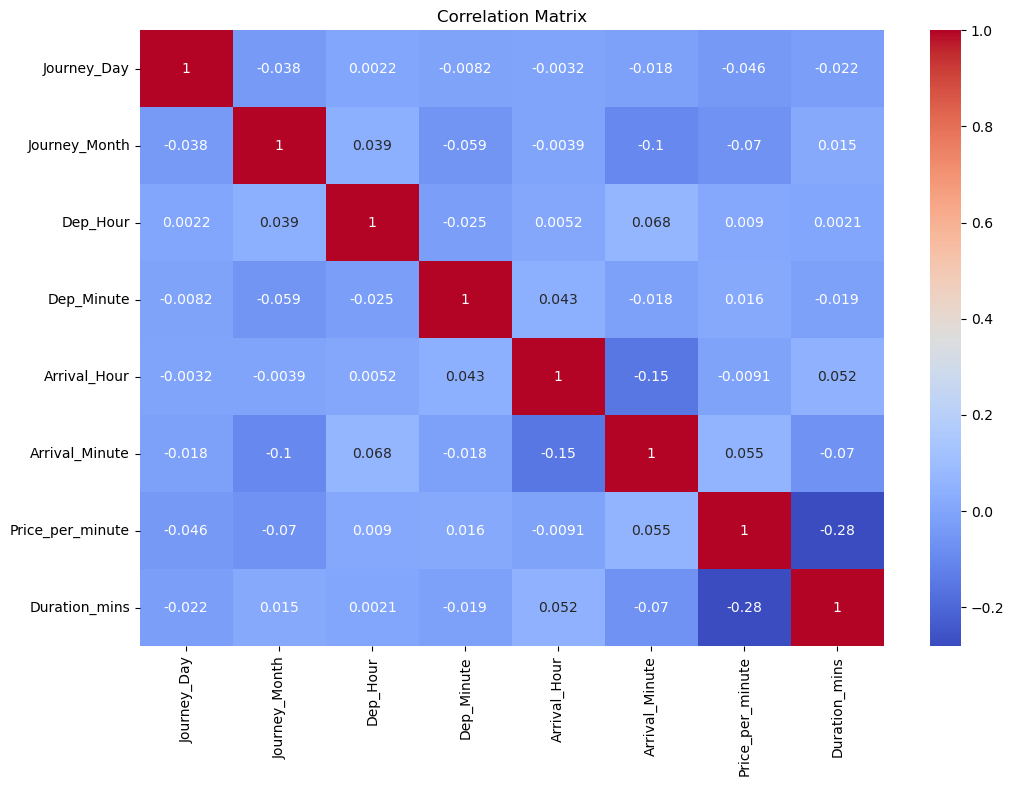

In [416]:
# Correlation heatmap
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

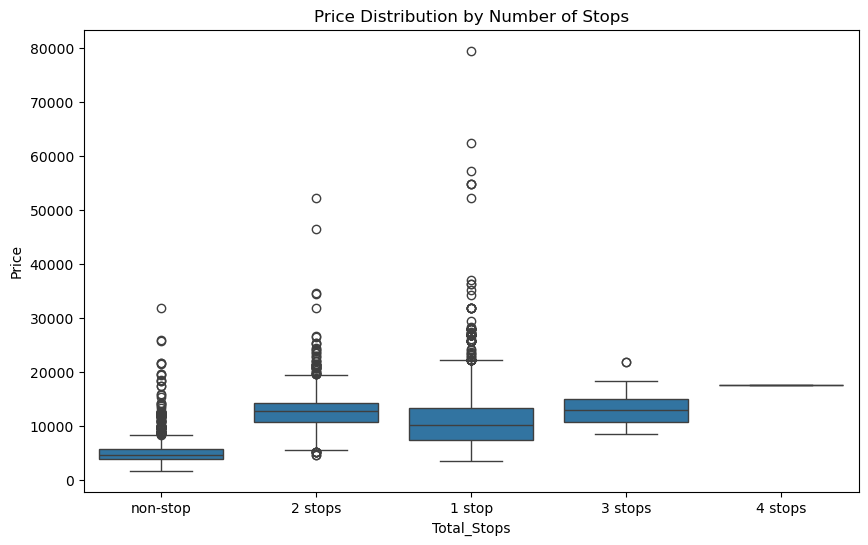

In [418]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Total_Stops', y='Price', data=df)
plt.title('Price Distribution by Number of Stops')
plt.show()

In [420]:
# Top 6 Most Expensive and Cheapest Routes
route_prices = df.groupby(['Source', 'Destination'])['Price'].mean().reset_index()
top_expensive = route_prices.nlargest(10, 'Price')
top_cheapest = route_prices.nsmallest(10, 'Price')

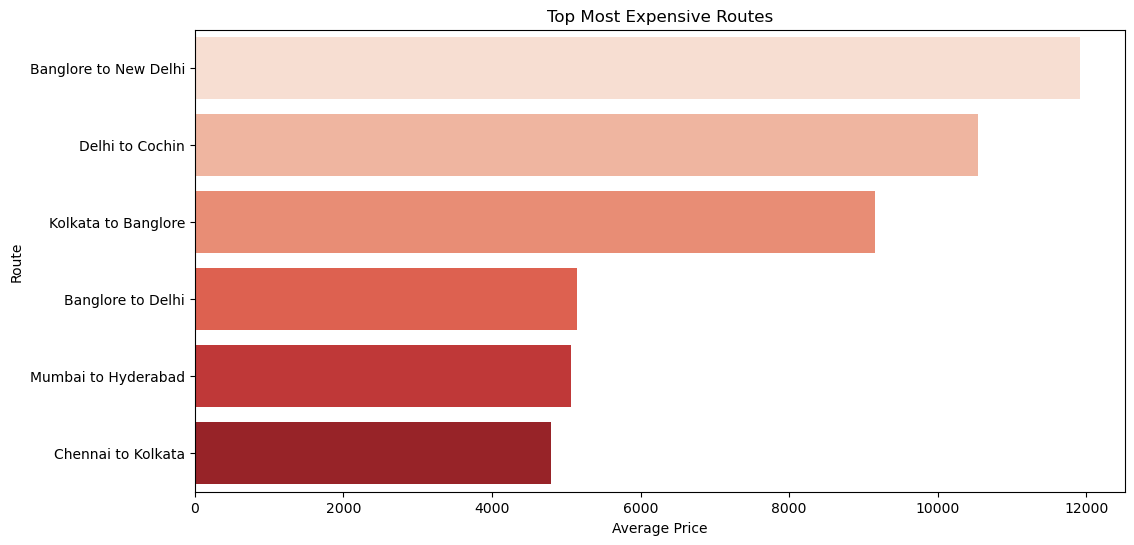

In [422]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Price', y='Route', data=top_expensive.assign(Route=top_expensive['Source'] + ' to ' + top_expensive['Destination']), palette='Reds')
plt.title('Top Most Expensive Routes')
plt.xlabel('Average Price')
plt.ylabel('Route')
plt.show()

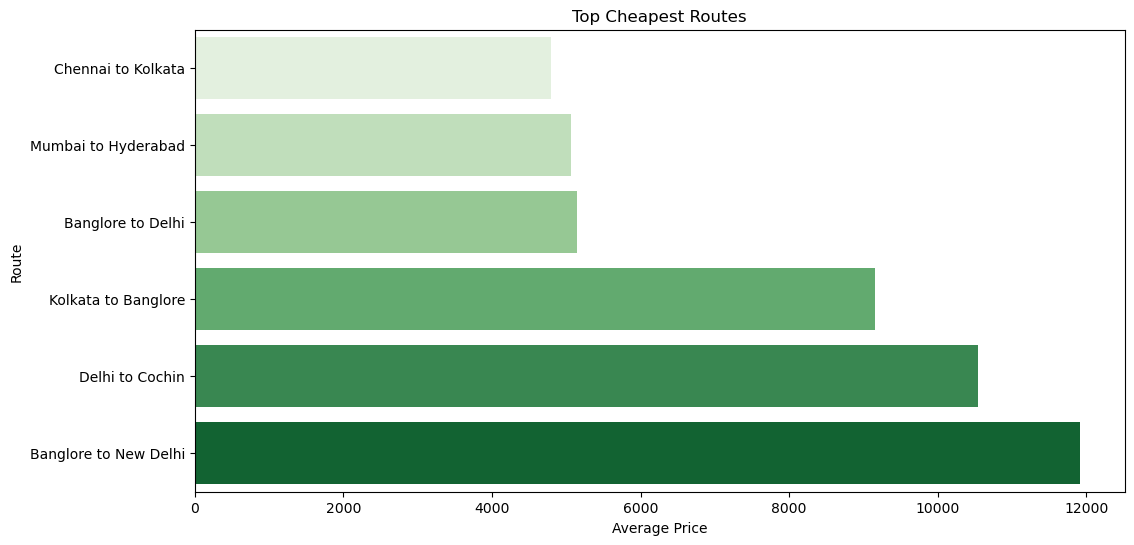

In [424]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Price', y='Route', data=top_cheapest.assign(Route=top_cheapest['Source'] + ' to ' + top_cheapest['Destination']), palette='Greens')
plt.title('Top Cheapest Routes')
plt.xlabel('Average Price')
plt.ylabel('Route')
plt.show()

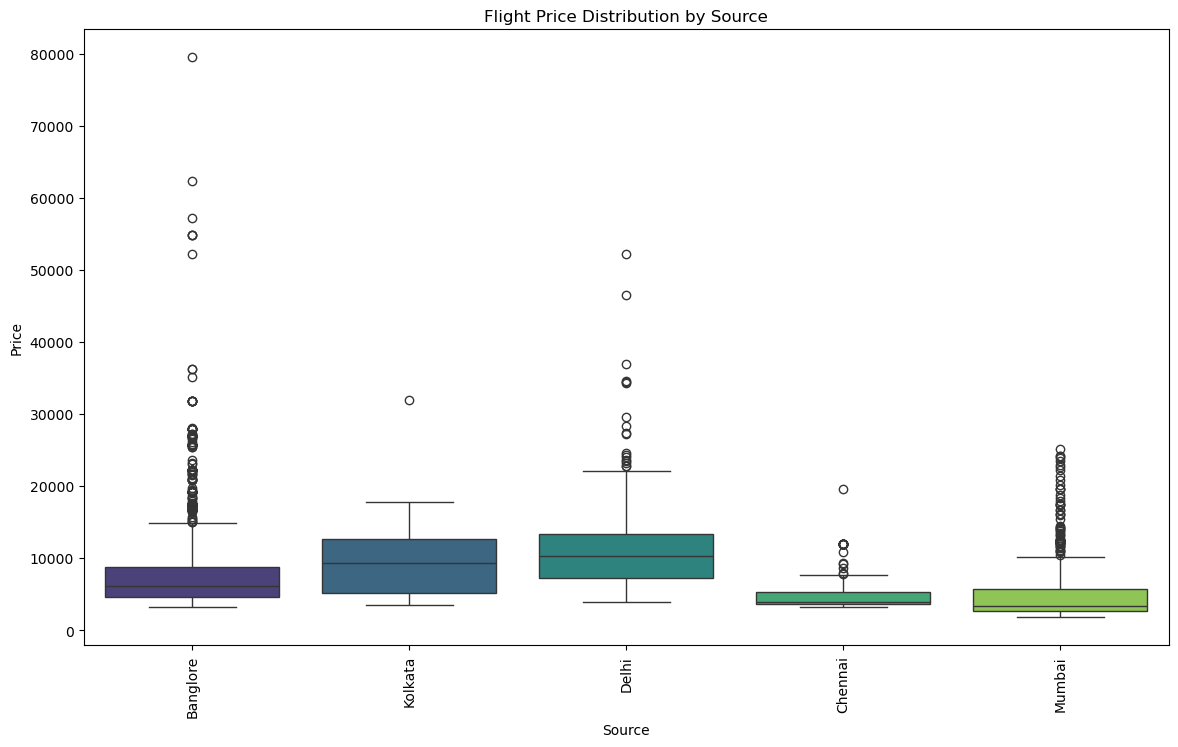

In [426]:
# Flight Price Distribution by Source and Destination
plt.figure(figsize=(14, 8))
sns.boxplot(x='Source', y='Price', data=df, palette='viridis')
plt.title('Flight Price Distribution by Source')
plt.xlabel('Source')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

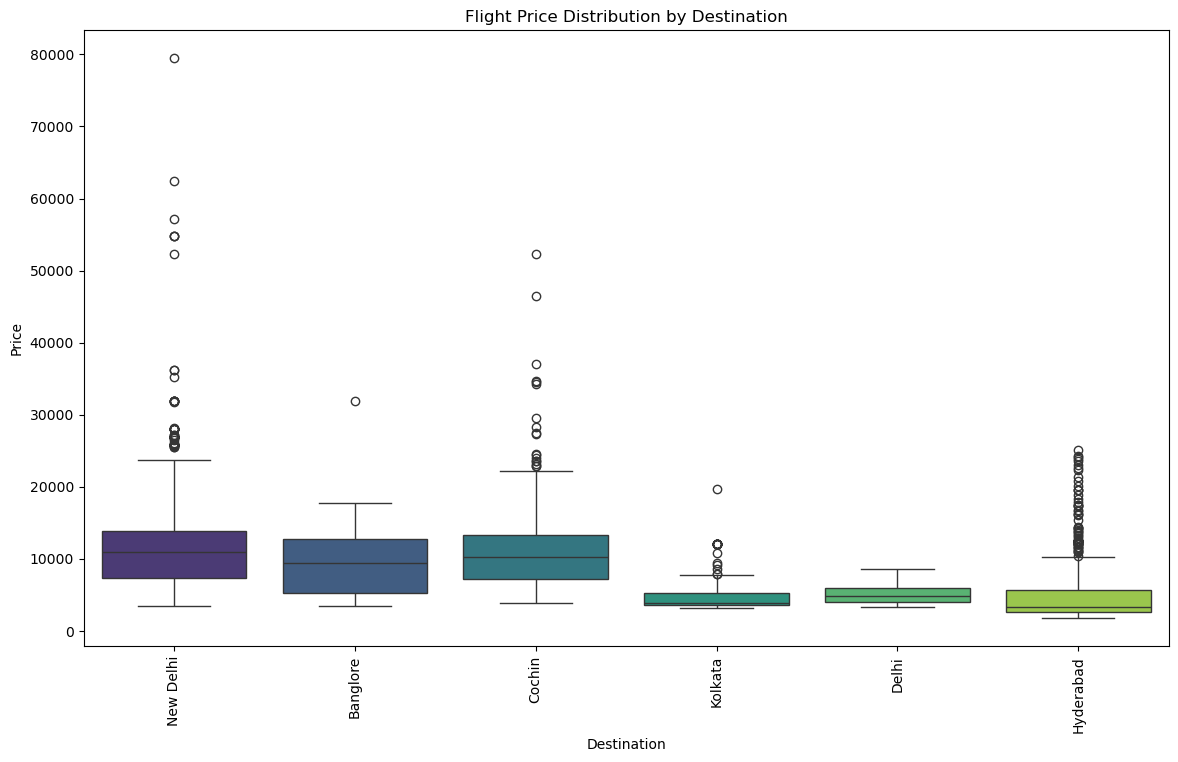

In [428]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Destination', y='Price', data=df, palette='viridis')
plt.title('Flight Price Distribution by Destination')
plt.xlabel('Destination')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

In [430]:
# Select features
features = [
    'Journey_Month', 'Journey_Day', 'Dep_Hour', 'Dep_Minute',
    'Arrival_Hour', 'Arrival_Minute', 'Duration_mins', 'Price_per_minute',
    'Airline_encoded', 'Source_encoded', 'Destination_encoded', 'Total_Stops_encoded',
    'Additional_Info_encoded', 'Route_1_encoded', 'Route_2_encoded', 'Route_3_encoded',
    'Route_4_encoded', 'Route_5_encoded', 'Route_6_encoded' 
]

X = df_encoded[features]
y = df_encoded['Price']

In [432]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [434]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso()
}

In [436]:
# Define hyperparameter grids for each model
param_grids = {
    'Linear Regression': {},  # No hyperparameters to tune
    'Random Forest': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2]
    },
    'XGBoost': {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 6, 9],
        'regressor__subsample': [0.8, 1.0],
        'regressor__colsample_bytree': [0.8, 1.0]
    },
    'Gradient Boosting': {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 6, 9],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2]
    },
    'SVR': {
        'regressor__C': [0.1, 1, 10],
        'regressor__kernel': ['linear', 'rbf'],
        'regressor__gamma': ['scale', 'auto']
    },
    'Decision Tree': {
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2]
    },
    'Ridge Regression': {
        'regressor__alpha': [0.1, 1, 10]
    },
    'Lasso Regression': {
        'regressor__alpha': [0.1, 1, 10]
    }
}

In [438]:
# Initialize MLflow
mlflow.set_experiment("Flight Price Prediction")
trained_models = {}
best_rmse = float('inf')
best_model = None

2025/02/23 19:52:15 INFO mlflow.tracking.fluent: Experiment with name 'Flight Price Prediction' does not exist. Creating a new experiment.


In [444]:
# Train, tune, save, and track models
for name, model in models.items():
    print(f"Training and tuning model: {name}")
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),  # Scale numerical features
        ('regressor', model)           # Add the model
    ])
    
    # Hyperparameter tuning
    if name in param_grids:
        print(f"Performing hyperparameter tuning for {name}...")
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids[name],
            scoring='neg_mean_squared_error',  # Use RMSE for regression
            cv=5,  # 5-fold cross-validation
            n_jobs=-1,  # Use all CPU cores
            verbose=1
        )
        grid_search.fit(X_train, y_train)
        
        # Get the best model
        best_pipeline = grid_search.best_estimator_
        trained_models[name] = best_pipeline
        
        # Log best hyperparameters
        print(f"Best hyperparameters for {name}: {grid_search.best_params_}")
    else:
        # Train without tuning (e.g., Linear Regression)
        pipeline.fit(X_train, y_train)
        trained_models[name] = pipeline
    
    # Save pipeline
    with open(f"{name}_pipeline.pkl", "wb") as f:
        pickle.dump(trained_models[name], f)
    
    # Evaluate
    y_pred = trained_models[name].predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R-squared: {r2:.2f}")
    
    # MLflow Tracking
    with mlflow.start_run(run_name=name):
        # Log model parameters
        if name in param_grids:
            for param_name, param_value in grid_search.best_params_.items():
                mlflow.log_param(param_name, param_value)
        
        # Log metrics
        mlflow.log_metrics({
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })
        
        # Log model
        mlflow.sklearn.log_model(trained_models[name], name)
        
        # Track best model
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = name

print(f"Best Model: {best_model} with RMSE: {best_rmse:.2f}")

Training and tuning model: Linear Regression
Performing hyperparameter tuning for Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters for Linear Regression: {}
Linear Regression - RMSE: 3135.41, MAE: 2195.01, R-squared: 0.54


2025/02/23 19:54:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training and tuning model: Random Forest
Performing hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters for Random Forest: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Random Forest - RMSE: 697.19, MAE: 99.89, R-squared: 0.98


2025/02/23 20:02:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training and tuning model: XGBoost
Performing hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyperparameters for XGBoost: {'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
XGBoost - RMSE: 538.63, MAE: 135.58, R-squared: 0.99


2025/02/23 20:04:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training and tuning model: Gradient Boosting
Performing hyperparameter tuning for Gradient Boosting...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyperparameters for Gradient Boosting: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 6, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Gradient Boosting - RMSE: 461.68, MAE: 101.65, R-squared: 0.99


2025/02/23 20:18:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training and tuning model: SVR
Performing hyperparameter tuning for SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters for SVR: {'regressor__C': 10, 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf'}
SVR - RMSE: 3768.16, MAE: 2495.06, R-squared: 0.34


2025/02/23 20:21:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training and tuning model: Decision Tree
Performing hyperparameter tuning for Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters for Decision Tree: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Decision Tree - RMSE: 524.06, MAE: 143.88, R-squared: 0.99


2025/02/23 20:21:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training and tuning model: Ridge Regression
Performing hyperparameter tuning for Ridge Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best hyperparameters for Ridge Regression: {'regressor__alpha': 10}
Ridge Regression - RMSE: 3135.73, MAE: 2195.01, R-squared: 0.54


2025/02/23 20:21:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training and tuning model: Lasso Regression
Performing hyperparameter tuning for Lasso Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best hyperparameters for Lasso Regression: {'regressor__alpha': 10}
Lasso Regression - RMSE: 3138.80, MAE: 2193.46, R-squared: 0.54


2025/02/23 20:21:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Model: Gradient Boosting with RMSE: 461.68


In [ ]:
'Journey_Month', 'Journey_Day', 'Dep_Hour', 'Dep_Minute',
    'Arrival_Hour', 'Arrival_Minute', 'Duration_mins', 'Price_per_minute',
    'Airline_encoded', 'Source_encoded', 'Destination_encoded', 'Total_Stops_encoded',
    'Additional_Info_encoded', 'Route_1_encoded', 'Route_2_encoded', 'Route_3_encoded',
    'Route_4_encoded', 'Route_5_encoded', 'Route_6_encoded' 

In [450]:
df.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_mins,Price_per_minute,Route_1,Route_2,Route_3,Route_4,Route_5,Route_6
0,IndiGo,Banglore,New Delhi,non-stop,No info,3897,3,24,22,20,1,10,170,22.923529,BLR,DEL,None,None,None,None
1,Air India,Kolkata,Banglore,2 stops,No info,7662,5,1,5,50,13,15,445,17.217978,CCU,IXR,BBI,BLR,None,None
2,Jet Airways,Delhi,Cochin,2 stops,No info,13882,6,9,9,25,4,25,1140,12.177193,DEL,LKO,BOM,COK,None,None
3,IndiGo,Kolkata,Banglore,1 stop,No info,6218,5,12,18,5,23,30,325,19.132308,CCU,NAG,BLR,None,None,None
4,IndiGo,Banglore,New Delhi,1 stop,No info,13302,3,1,16,50,21,35,285,46.673684,BLR,NAG,DEL,None,None,None


In [448]:
df_encoded.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,...,Source_encoded,Destination_encoded,Total_Stops_encoded,Additional_Info_encoded,Route_1_encoded,Route_2_encoded,Route_3_encoded,Route_4_encoded,Route_5_encoded,Route_6_encoded
0,IndiGo,Banglore,New Delhi,non-stop,No info,3897,3,24,22,20,...,0,5,4,8,0,10,21,10,4,1
1,Air India,Kolkata,Banglore,2 stops,No info,7662,5,1,5,50,...,3,0,1,8,2,20,1,3,4,1
2,Jet Airways,Delhi,Cochin,2 stops,No info,13882,6,9,9,25,...,2,1,1,8,3,27,4,5,4,1
3,IndiGo,Kolkata,Banglore,1 stop,No info,6218,5,12,18,5,...,3,0,0,8,2,29,3,10,4,1
4,IndiGo,Banglore,New Delhi,1 stop,No info,13302,3,1,16,50,...,0,5,0,8,0,29,7,10,4,1


In [452]:
# Example Prediction using Best Model
best_pipeline = trained_models[best_model]
new_data = pd.DataFrame([{
    'Journey_Month': 3,
    'Journey_Day': 5,
    'Dep_Hour': 22,
    'Dep_Minute': 20,
    'Arrival_Hour': 1,
    'Arrival_Minute': 10,
    'Duration_mins': 170,
    'Price_per_minute': 22.92,
    'Airline_encoded': 0,
    'Source_encoded': 0,
    'Destination_encoded': 5,
    'Total_Stops_encoded': 4,
    'Additional_Info_encoded': 8,
    'Route_1_encoded': 0,
    'Route_2_encoded': 10,
    'Route_3_encoded': 21,
    'Route_4_encoded': 10,
    'Route_5_encoded': 4,
    'Route_6_encoded': 1
}])

In [458]:
predicted_price = best_pipeline.predict(new_data)
print(f"Predicted Flight Price: ₹{predicted_price[0]:.2f}")

Predicted Flight Price: ₹3874.86


In [466]:
df.to_csv('Cleaned_Flight_Price.csv')

In [472]:
df_encoded = df_encoded.drop(['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info', 'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5', 'Route_6'], axis=1)

In [474]:
df_encoded.to_csv('Cleaned.csv')